In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import seaborn as sns

## Simulation notes
For the simulation, the time is following this convention:
1 time unit = 10 ms


In [56]:
def epileptor(q, parameters):

	x1,y1,z,x2,y2,g = q
	a1, b1, c1, d1, tau, a2, c2, m, x0, r, s, Irest1, Irest2, Is1, Is2 =\
    parameters['a1'], parameters['b1'], parameters['c1'], parameters['d1'], parameters['tau'], \
    parameters['a2'], parameters['c2'], parameters['m'], parameters['x0'], parameters['r'], \
    parameters['s'], parameters['Irest1'], parameters['Irest2'], parameters['Is1'], parameters['Is2']
    
    ###################  Population 1 #################
	if x1 < 0:
		dx1 = y1  - a1 * (x1)**3  + b1 * (x1)**2 - z + Irest1 + Is1
	else:
		dx1 = y1 + (m -x2 + 0.6 * (z-4)**2)*x1- z + Irest1 + Is1
	dy1 = c1 - d1 * (x1)**2 - y1

	################## Population 2 ################### 
	dx2 = -y2 + x2 - (x2)**3 + Irest2 + 2*g - c2*(z-3.5) + Is2
	if x2 < -0.25:
		dy2 = 1./tau * (-y2)
	else:
		dy2 = 1./tau * (-y2 + a2 * (x2 + 0.25 ))
	dg = -0.01 * (g - 0.1*x1);

	################### Energy #####################"
	dz = r* (s * (x1 - x0) -z)
	#pdb.set_trace()
	return np.hstack((dx1, dy1, dz, dx2, dy2, dg))


Is1a = np.arange(0.1, 5.2, .5)
Is2a = np.arange(0.1, 10.2, 1)
lx0 = [-2.2, -2.25, -2.3]
lllq = []
for x0 in lx0:
    llq = []
    for Is1, Is2 in zip(Is1a, Is2a):
        print(Is1)
        print(Is2)

        # Parameters
        parameters = {'a1':1, 'b1':3, 'c1':1, 'd1':5,
                      'tau':10, 'a2':6, 'c2':0.3, 'm':0,
                      'x0':x0, 'r':0.00005, 's':4,
                      'Irest1':3.1, 'Irest2':0.45, 'Is1':0, 'Is2':0}

        # Find initial conditions by root solving
        q0 = [-1.37, -8.39,  2.92, -0.71,  0.  , -0.14]
        q = fsolve(epileptor, q0, args=parameters)

        # sim parameters
        dt = 0.001
        t_sim_init = 200
        n_samples_init = int(t_sim_init/dt)
        t_sim = 2000
        n_samples = int(t_sim/dt)
        upsamp = 10
        t = np.linspace(0, t_sim, t_sim*upsamp)

        # stim parameters
        t_start = 25
        I_inter = 25
        I_duration = .3
        n_stim = 1

        stim = 1
        parameters['Is2'] = 0
        for it in range(n_samples_init):
            # Runge-Kutta scheme
            p1 = epileptor(q, parameters)
            p2 = epileptor(q+(dt/2)*p1, parameters)
            p3 = epileptor(q+(dt/2)*p2, parameters)
            p4 = epileptor(q+(dt/2)*p3, parameters)
            q += dt/6 * (p1+2*p2+2*p3+p4)

        lq = []
        for it in range(n_samples):
            # if it%10000==0:
            #     print(it)
            tc = it*dt

            tstim = 0
            if stim:
                for i_stim in range(n_stim):
                    if tc>=t_start + i_stim*I_duration + i_stim*I_inter and tc<t_start + (i_stim+1)*I_duration + i_stim*I_inter:
                        tstim = 1
            if tstim:
                parameters['Is1'] = Is1
                parameters['Is2'] = Is2
            else:
                parameters['Is1'] = 0
                parameters['Is2'] = 0

            # Runge-Kutta scheme
            p1 = epileptor(q, parameters)
            p2 = epileptor(q+(dt/2)*p1, parameters)
            p3 = epileptor(q+(dt/2)*p2, parameters)
            p4 = epileptor(q+(dt/2)*p3, parameters)
            q += dt/6 * (p1+2*p2+2*p3+p4)

            if it%int(1/(upsamp*dt))==0:
                lq.append(q.copy())
                
        llq.append(lq)
    lllq.append(llq)
lllq = np.array(lllq)

0.1
0.1
0.6
1.1
1.1
2.1
1.6
3.1
2.1
4.1
2.6
5.1
3.1
6.1
3.6
7.1
4.1
8.1
4.6
9.1
5.1
10.1
0.1
0.1
0.6
1.1
1.1
2.1
1.6
3.1
2.1
4.1
2.6
5.1
3.1
6.1
3.6
7.1
4.1
8.1
4.6
9.1
5.1
10.1
0.1
0.1
0.6
1.1
1.1
2.1
1.6
3.1
2.1
4.1
2.6
5.1
3.1
6.1
3.6
7.1
4.1
8.1
4.6
9.1
5.1
10.1


In [57]:
lllq.shape

(3, 11, 20000, 6)

### Time series

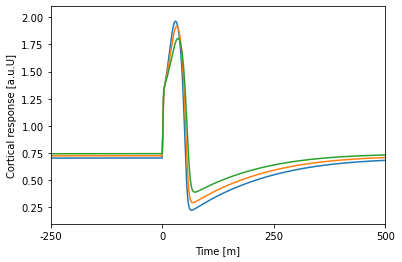

In [100]:
cm = sns.color_palette(as_cmap=True)
ts = -lllq[:, :, :, 0] + lllq[:, :, :, 3]
plt.figure()
for ix0, x0 in enumerate(lx0):
    iIs2 = int(np.where(Is2a==2.1)[0])
    # time in seconds
    plt.plot(t/100, ts[ix0, iIs2], color=cm[ix0])
plt.xlim([0, .75])
plt.xticks([0, .25, .5, .75], [-250, 0, 250, 500])
plt.ylim([0.1, 2.1])
plt.xlabel('Time [m]')
plt.ylabel('Cortical response [a.u.U]')
plt.savefig('figures/single_stim_diff_exc_time_series.svg')

### LL as a function of stimulation amplitude

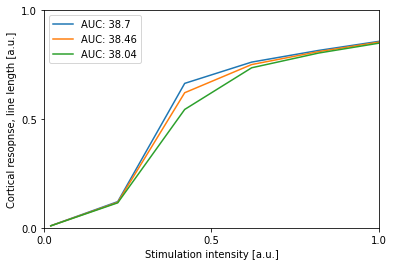

In [107]:
from scipy.integrate import simps

plt.figure()
for ix0, x0 in enumerate(lx0):
    t_stim_onsets= []
    for iIs2 in range(ts.shape[1]):
        tc = (t_start + i_stim*I_duration + i_stim*I_inter)*upsamp
        t_stim_onsets.append(tc)

    dif = []
    for iIs2 in range(ts.shape[1]):
        dif.append(np.sum(np.abs(np.diff(ts[ix0, iIs2, int(t_stim_onsets[iIs2]):int(t_stim_onsets[iIs2]+25*upsamp)]))))

    plt.plot(Is2a, dif, color=cm[ix0], label='AUC: '+ str(np.round(simps(dif, Is2a), 2)))
    # plt.xticks(range(len(dif)), np.round(lx0, 2))
plt.xlim([0, 5.])
plt.ylim([0, 5.])
plt.xticks([0, 2.5, 5], [0.0, 0.5, 1.0])
plt.yticks([0, 2.5, 5], [0.0, 0.5, 1.0])
plt.ylabel('Cortical resopnse, line length [a.u.]')
plt.xlabel('Stimulation intensity [a.u.]')
plt.legend()
plt.savefig('figures/single_stim_diff_exc_LL_vs_stim_amp.svg')